# Seq2Seq Approach for generating Mega Millions Numbers  
forked from: https://www.kaggle.com/code/gogo827jz/lotto-prediction/notebook

model theory:
https://towardsdatascience.com/day-1-2-attention-seq2seq-models-65df3f49e263

experiment for free:
https://colab.research.google.com/

In [21]:
import gc
import os
import math
import numpy as np
import pandas as pd
from numba import njit
from numpy import sqrt, sin, cos, pi, zeros
from numpy.random import randn, rand, uniform, normal
from scipy.linalg import hadamard
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Activation, LSTM, Dropout, RepeatVector, TimeDistributed, Embedding, Reshape, Dot, Concatenate
from tensorflow.keras.layers import GRU, SpatialDropout1D, Conv1D, GlobalMaxPooling1D,Multiply, Lambda, Softmax, Flatten, BatchNormalization, Bidirectional, dot, concatenate
from tensorflow.keras.layers import AdditiveAttention, Attention
from tensorflow.keras.activations import relu
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import callbacks
from tensorflow.keras import backend
from tensorflow.keras.utils import plot_model
from tensorflow.keras.metrics import MeanSquaredError
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

print("Tensorflow version " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE

Tensorflow version 2.9.2


# Configurations

In [22]:
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [23]:
MIXED_PRECISION = False
XLA_ACCELERATE = True

if MIXED_PRECISION:
    from tensorflow.keras.mixed_precision import experimental as mixed_precision
    if tpu: policy = tf.keras.mixed_precision.experimental.Policy('mixed_bfloat16')
    else: policy = tf.keras.mixed_precision.experimental.Policy('mixed_float16')
    mixed_precision.set_policy(policy)
    print('Mixed precision enabled')

if XLA_ACCELERATE:
    tf.config.optimizer.set_jit(True)
    print('Accelerated Linear Algebra enabled')

Accelerated Linear Algebra enabled


# Mount Google Drive, Get the Dataset


In [24]:
import pandas as pd
from google.colab import drive, files
import numpy as np

filename = 'MegaMillionsQ123WxExtras.csv'

drive.mount('/content/drive/')
output_directory = "/content/drive/My Drive/"
lotto = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/LottoPredictions/data/' + filename, index_col = 'Date')
lotto = lotto.drop(['BB', 'RH','PD','TMP', 'TMP2', 'TMP3'], axis = 1)
print(lotto)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
            B1  B2  B3  B4  B5  B6  LC
Date                                  
2023-01-06   3  20  46  59  63  13   3
2023-01-03  25  29  33  41  44  18   2
2022-12-30   1   3   6  44  51   7   2
2022-12-27   9  13  36  59  61  11   1
2022-12-23  15  21  32  38  62   8   1
...         ..  ..  ..  ..  ..  ..  ..
2017-11-07   1  54  60  68  69  11   3
2017-11-03  10  22  42  61  69   3   3
2017-10-31   6  28  31  52  53  12   2
2017-10-27  17  27  41  51  52  13   2
2017-10-24  20  24  34  56  64   6   1

[544 rows x 7 columns]


# Train Test Split
Use the last 50 draws as the test dataset
Use a sliding window of 10 to split the input data

In [25]:
#infer training epocs from len of dataframe:

data = lotto.values - 1

#tf.keras.utils.normalize(data)
assert not np.any(np.isnan(data))

train = data[:-50]
test = data[-50:]

w = 10
X_train = []
y_train = []
for i in range(w, len(train)):
    X_train.append(train[i - w: i, :])
    y_train.append(train[i])
X_train, y_train = np.array(X_train), np.array(y_train)

inputs = data[data.shape[0] - test.shape[0] - w:]
X_test = []
for i in range(w, inputs.shape[0]):
    X_test.append(inputs[i - w: i, :])
X_test = np.array(X_test)
y_test = test

In [26]:
print('<nans>')
assert not np.any(np.isnan(X_train))
assert not np.any(np.isnan(y_train))
print ('</nans>')
print(data.shape)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

<nans>
</nans>
(544, 7)
(484, 10, 7)
(484, 7)
(50, 10, 7)
(50, 7)


# Seq2Seq Model to Predict Future Draws

Input the last 10 draws and sequentially predict the next draw.
Monitor the performance by sparse categorical crossentropy and sparse top k categorical accuracy.

In [27]:
src_parameters = 7

#70 because mega millions white balls cap at 70
embed_dim = (70 // 2) + 1
dropout_rate = 0.5
spatial_dropout_rate = 0.5
steps_before = w
steps_after = src_parameters
feature_count = embed_dim * src_parameters
hidden_neurons = [64, 32] 
bidirectional = True
attention_style = 'Bahdanau' # or 'Luong'
#ref: https://machinelearningmastery.com/the-bahdanau-attention-mechanism/ or https://arxiv.org/pdf/1508.04025.pdf section 3.1 for differences

In [28]:
with strategy.scope():
    
    inp0 = Input(shape = (w, X_train.shape[2]))
    
    # Embed 70 categories into a 35-dimension continuous-number vector for each ball
    # largest value and largest value /2

    #these will be used to auto label instead of the manual zero hot encoding
    inp1 = Lambda(lambda x: x[:, :, 0])(inp0)
    inp1 = Embedding(70, embed_dim)(inp1)
    inp1 = SpatialDropout1D(spatial_dropout_rate)(inp1)
    
    inp2 = Lambda(lambda x: x[:, :, 1])(inp0)
    inp2 = Embedding(70, embed_dim)(inp2)
    inp2 = SpatialDropout1D(spatial_dropout_rate)(inp2)
    
    inp3 = Lambda(lambda x: x[:, :, 2])(inp0)
    inp3 = Embedding(70, embed_dim)(inp3)
    inp3 = SpatialDropout1D(spatial_dropout_rate)(inp3)

    inp4 = Lambda(lambda x: x[:, :, 3])(inp0)
    inp4 = Embedding(70, embed_dim)(inp4)
    inp4 = SpatialDropout1D(spatial_dropout_rate)(inp4)
    
    inp5 = Lambda(lambda x: x[:, :, 4])(inp0)
    inp5 = Embedding(70, embed_dim)(inp5)
    inp5 = SpatialDropout1D(spatial_dropout_rate)(inp5)

    #this one should actually be 25 but.. the last ball was actually pretty good.
    inp6 = Lambda(lambda x: x[:, :, 5])(inp0)
    inp6 = Embedding(25, (25 //2 ) + 1)(inp6)
    inp6 = SpatialDropout1D(spatial_dropout_rate)(inp6)

    inp7 = Lambda(lambda x: x[:, :, 6])(inp0)
    inp7 = Embedding(70, embed_dim)(inp7)
    inp7 = SpatialDropout1D(spatial_dropout_rate)(inp7)

    #inp8 = Lambda(lambda x: x[:, :, 7])(inp0)
    #inp8 = Embedding(200, (200//2)+1)(inp8)
    #inp8 = SpatialDropout1D(spatial_dropout_rate)(inp8)

    #inp9 = Lambda(lambda x: x[:, :, 7])(inp0)
    #inp9 = Embedding(3000, (3000 // 2) + 1)(inp9)
    #inp9 = SpatialDropout1D(spatial_dropout_rate)(inp9)

    inp = Concatenate()([inp1, inp2, inp3, inp4, inp5, inp6, inp7])
    
    # Seq2Seq model with attention or bidirectional encoder
    
    num_layers = len(hidden_neurons)
    
    sh_list, h_list, c_list = [inp], [], []
    
    if bidirectional:
        
        for i in range(num_layers):
    
            sh, fh, fc, bh, bc = Bidirectional(LSTM(hidden_neurons[i],
                                                    dropout = dropout_rate, 
                                                    return_state = True, 
                                                    return_sequences = True))(sh_list[-1])
        
            h = Concatenate()([fh, bh])
            c = Concatenate()([fc, bc]) 

            sh_list.append(sh)
            h_list.append(h)
            c_list.append(c)
        
    else:
    
        for i in range(num_layers):

            sh, h, c = LSTM(hidden_neurons[i], 
                            dropout = dropout_rate,
                            return_state = True, 
                            return_sequences = True)(sh_list[-1])

            sh_list.append(sh)
            h_list.append(h)
            c_list.append(c)
    
    decoder = RepeatVector(steps_after)(h_list[-1])
    
    if bidirectional:
        
        decoder_hidden_neurons = [hn * 2 for hn in hidden_neurons]
        
    else:
        
        decoder_hidden_neurons = hidden_neurons
    
    for i in range(num_layers):
        
        decoder = LSTM(decoder_hidden_neurons[i],
                       dropout = dropout_rate, 
                       return_sequences = True)(decoder, initial_state = [h_list[i], c_list[i]])
       
    if attention_style == 'Bahdanau':
        
        context = AdditiveAttention(dropout = dropout_rate)([decoder, sh_list[-1]])
        
        decoder = concatenate([context, decoder])
        
    elif attention_style == 'Luong':
        
        context = Attention(dropout = dropout_rate)([decoder, sh_list[-1]])
        
        decoder = concatenate([context, decoder])
    
    out = Dense(70, activation = 'softmax')(decoder)

    model = Model(inputs = inp0, outputs = out)
    
    sparse_top_k = tf.keras.metrics.SparseTopKCategoricalAccuracy(k = 5, name = 'sparse_top_k')
   
    model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = [sparse_top_k])
    #model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = [sparse_top_k])

In [29]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 10, 7)]      0           []                               
                                                                                                  
 lambda_7 (Lambda)              (None, 10)           0           ['input_2[0][0]']                
                                                                                                  
 lambda_8 (Lambda)              (None, 10)           0           ['input_2[0][0]']                
                                                                                                  
 lambda_9 (Lambda)              (None, 10)           0           ['input_2[0][0]']                
                                                                                            

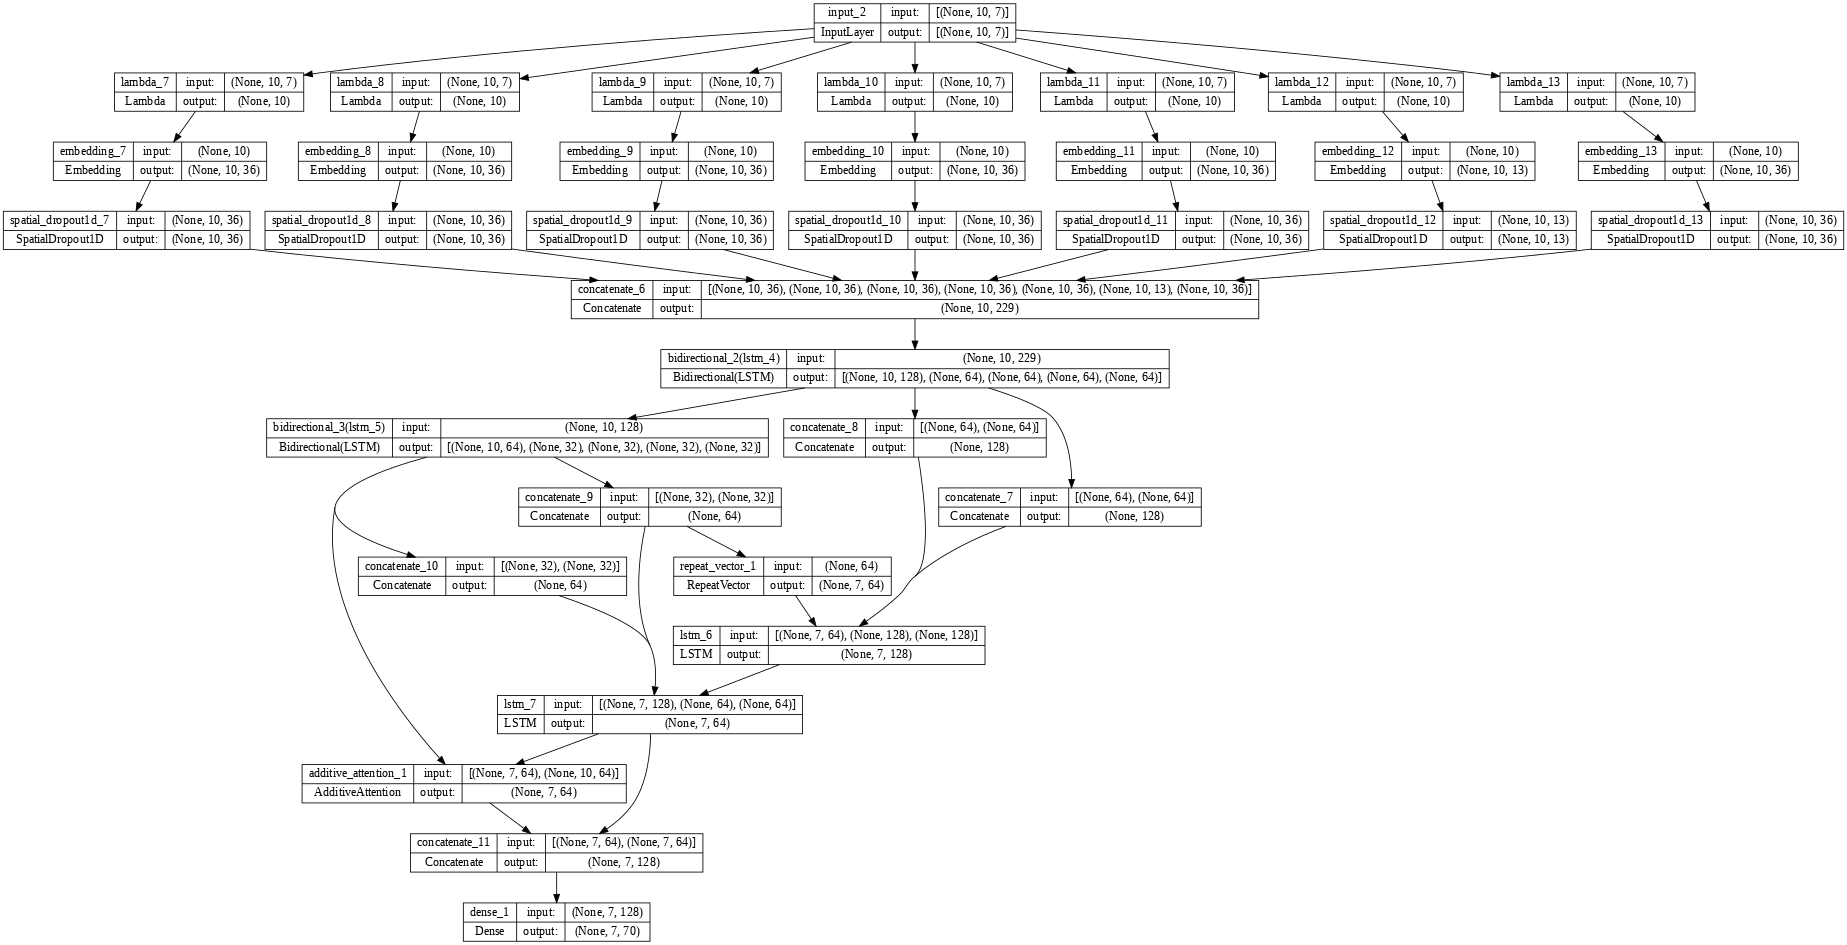

In [30]:
plot_model(model, show_shapes = True, show_layer_names = True, rankdir = 'TB', dpi = 60)

In [31]:
class CosAnnealer(callbacks.Callback):
    """Cosine annealing
    """

    def __init__(self, T_max, eta_max, eta_min = 0, verbose = 0):
        super(CosAnnealer, self).__init__()
        self.T_max = T_max
        self.eta_max = eta_max
        self.eta_min = eta_min
        self.verbose = verbose

    def on_epoch_begin(self, epoch, logs = None):
        if not hasattr(self.model.optimizer, 'lr'):
            raise ValueError('Optimizer must have a "lr" attribute.')
        lr = self.eta_min + (self.eta_max - self.eta_min) * (1 + math.cos(math.pi * epoch / self.T_max)) / 2
        backend.set_value(self.model.optimizer.lr, lr)
        if self.verbose > 0:
            print('\nEpoch %05d: CosineAnnealer setting learning '
                  'rate to %s.' % (epoch + 1, lr))

    def on_epoch_end(self, epoch, logs = None):
        logs = logs or {}
        logs['lr'] = backend.get_value(self.model.optimizer.lr)

In [32]:
training_basis = 256 # 768 #(len(lotto) * 1)
EPOCHS = int(training_basis)
BATCH_SIZE = 32
LR_MAX = 1e-4
LR_MIN = 1e-5

cas = CosAnnealer(EPOCHS, LR_MAX, LR_MIN)

ckp = callbacks.ModelCheckpoint('model_candidate.hdf5', monitor = 'val_sparse_top_k', verbose = 0, 
                                save_best_only = True, save_weights_only = False, mode = 'max')

history = model.fit(X_train, y_train, 
                    validation_data = (X_test, y_test), 
                    callbacks = [ckp, cas], 
                    epochs = EPOCHS, 
                    batch_size = BATCH_SIZE, 
                    verbose = 2)

hist = pd.DataFrame(history.history)

Epoch 1/256
16/16 - 48s - loss: 4.2471 - sparse_top_k: 0.0850 - val_loss: 4.2461 - val_sparse_top_k: 0.1743 - lr: 1.0000e-04 - 48s/epoch - 3s/step
Epoch 2/256
16/16 - 1s - loss: 4.2447 - sparse_top_k: 0.1328 - val_loss: 4.2431 - val_sparse_top_k: 0.2143 - lr: 9.9997e-05 - 1s/epoch - 74ms/step
Epoch 3/256
16/16 - 1s - loss: 4.2415 - sparse_top_k: 0.1842 - val_loss: 4.2392 - val_sparse_top_k: 0.2257 - lr: 9.9986e-05 - 1s/epoch - 73ms/step
Epoch 4/256
16/16 - 1s - loss: 4.2368 - sparse_top_k: 0.2054 - val_loss: 4.2330 - val_sparse_top_k: 0.2286 - lr: 9.9970e-05 - 1s/epoch - 71ms/step
Epoch 5/256
16/16 - 1s - loss: 4.2294 - sparse_top_k: 0.2205 - val_loss: 4.2213 - val_sparse_top_k: 0.2286 - lr: 9.9946e-05 - 1s/epoch - 65ms/step
Epoch 6/256
16/16 - 1s - loss: 4.2130 - sparse_top_k: 0.2226 - val_loss: 4.1942 - val_sparse_top_k: 0.2286 - lr: 9.9915e-05 - 1s/epoch - 68ms/step
Epoch 7/256
16/16 - 1s - loss: 4.1713 - sparse_top_k: 0.2205 - val_loss: 4.1222 - val_sparse_top_k: 0.2286 - lr: 9.987

0.34857141971588135


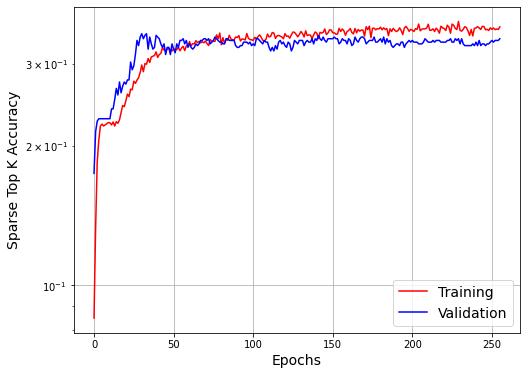

In [33]:
print(hist['val_sparse_top_k'].max())

plt.figure(figsize = (8, 6))
plt.semilogy(hist['sparse_top_k'], '-r', label = 'Training')
plt.semilogy(hist['val_sparse_top_k'], '-b', label = 'Validation')
plt.ylabel('Sparse Top K Accuracy', fontsize = 14)
plt.xlabel('Epochs', fontsize = 14)
plt.legend(fontsize = 14)
plt.grid()
plt.show()

# Predict the Test Dataset

In [34]:
model.load_weights('model_candidate.hdf5')
pred = model.predict(X_test)
pred = np.argmax(pred, axis = 2)

2/2 [==============================] - 3s 15ms/step


In [35]:
for i in range(y_test.shape[0]):
    print('Prediction:\t', pred[i] + 1)
    print('Actual:\t', y_test[i] + 1)
    print('-' * 40)

Prediction:	 [ 7 14 38 43 64  4  2]
Actual:	 [ 8  9 32 42 59 10  4]
----------------------------------------
Prediction:	 [ 7 14 38 43 64  4  2]
Actual:	 [ 5 13 31 43 53 20  4]
----------------------------------------
Prediction:	 [ 7 14 38 43 64  4  2]
Actual:	 [16 33 51 54 67 20  3]
----------------------------------------
Prediction:	 [ 7 14 38 43 64  4  2]
Actual:	 [ 4 29 39 42 62 14  3]
----------------------------------------
Prediction:	 [ 7 14 43 43 64  4  2]
Actual:	 [11 28 31 46 59  1  2]
----------------------------------------
Prediction:	 [ 7 14 38 43 64  4  2]
Actual:	 [ 7 25 43 56 59 13  2]
----------------------------------------
Prediction:	 [ 7 14 38 43 64  4  2]
Actual:	 [ 4  8 23 53 59 17  1]
----------------------------------------
Prediction:	 [ 7 14 43 43 64  4  2]
Actual:	 [14 38 51 64 70  9  1]
----------------------------------------
Prediction:	 [ 7 14 43 43 64  4  2]
Actual:	 [ 1 13 26 33 52 11  4]
----------------------------------------
Prediction:	 [ 7 14

# Predict the Future Draw on 2023-01-13

The Beam Search method will output 10 possible draws.  Though, they aren't very diverse in respect of your typical play card use case.

In [36]:
X_latest = X_test[-1][1:]
X_latest = np.concatenate([X_latest, y_test[-1].reshape(1, src_parameters)], axis = 0)
X_latest = X_latest.reshape(1, X_latest.shape[0], X_latest.shape[1])
print(X_latest + 1)

[[[16 36 54 61 64 22  1]
  [ 3  7 22 27 50  3  4]
  [ 3 26 55 58 70 15  4]
  [ 1 14 21 22 28 19  4]
  [ 6 23 38 42 58 24  4]
  [ 1 54 60 68 69 11  3]
  [10 22 42 61 69  3  3]
  [ 6 28 31 52 53 12  2]
  [17 27 41 51 52 13  2]
  [20 24 34 56 64  6  1]]]


In [37]:
# beam search  ref: https://www.width.ai/post/what-is-beam-search
def do_beam_search(data, k, replace = True):
    sequences = [[list(), 0.0]]
    # walk over each step in sequence
    for row in data:
        all_candidates = list()
        # expand each current candidate
        for i in range(len(sequences)):
            seq, score = sequences[i]
            best_k = np.argsort(row)[-k:]
            for j in best_k:
                candidate = [seq + [j], score + math.log(row[j])]
                if replace:
                    all_candidates.append(candidate)
                elif (replace == False) and (len(set(candidate[0])) == len(candidate[0])):
                    all_candidates.append(candidate)
        # order all candidates by score
        ordered = sorted(all_candidates, key = lambda tup:tup[1], reverse = True)
        # select k best
        sequences = ordered[:k]
    return sequences

In [38]:
pred_latest = model.predict(X_latest)
pred_latest = np.squeeze(pred_latest)
pred_latest_greedy = np.argmax(pred_latest, axis = 1)
print(pred_latest_greedy + 1)

1/1 [==============================] - 0s 24ms/step
[ 7 14 38 43 64  4  2]


This would allow for duplicate balls, doesn't apply for Mega Millions

In [39]:
beam_width = 10
replace = True

result = do_beam_search(pred_latest, beam_width, replace)
print('Beam Width:\t', beam_width)
print('Replace:\t', replace)
print('-' * 85)
for seq in result:
    print('Prediction: ', np.array(seq[0]) + 1, '\tLog Likelihood: ', seq[1])

Beam Width:	 10
Replace:	 True
-------------------------------------------------------------------------------------
Prediction:  [ 7 14 38 43 64  4  2] 	Log Likelihood:  -20.204373697172915
Prediction:  [ 7 14 43 43 64  4  2] 	Log Likelihood:  -20.21913313847464
Prediction:  [ 7 14 38 43 64  4  1] 	Log Likelihood:  -20.220208033961956
Prediction:  [ 7  7 38 43 64  4  2] 	Log Likelihood:  -20.225944605067596
Prediction:  [ 7 14 43 43 64  4  1] 	Log Likelihood:  -20.23496747526368
Prediction:  [ 7 14 48 43 64  4  2] 	Log Likelihood:  -20.238501045564476
Prediction:  [ 7  7 43 43 64  4  2] 	Log Likelihood:  -20.24070404636932
Prediction:  [ 7  7 38 43 64  4  1] 	Log Likelihood:  -20.241778941856637
Prediction:  [ 7 14 31 43 64  4  2] 	Log Likelihood:  -20.253188953013503
Prediction:  [ 7 14 48 43 64  4  1] 	Log Likelihood:  -20.254335382353517


This removes any duplicate balls on the same play, more realistic for Mega Millions

In [40]:
beam_width = 10
replace = False

result = do_beam_search(pred_latest, beam_width, replace)
print('Beam Width:\t', beam_width)
print('Replace:\t', replace)
print('-' * 85)
for seq in result:
    print('Prediction: ', np.array(seq[0]) + 1, '\tLog Likelihood: ', seq[1])

Beam Width:	 10
Replace:	 False
-------------------------------------------------------------------------------------
Prediction:  [ 7 14 38 43 64  4  2] 	Log Likelihood:  -20.204373697172915
Prediction:  [ 7 14 38 43 64  4  1] 	Log Likelihood:  -20.220208033961956
Prediction:  [ 7 14 48 43 64  4  2] 	Log Likelihood:  -20.238501045564476
Prediction:  [ 7 14 31 43 64  4  2] 	Log Likelihood:  -20.253188953013503
Prediction:  [ 7 14 48 43 64  4  1] 	Log Likelihood:  -20.254335382353517
Prediction:  [ 7 14 31 43 64  4  1] 	Log Likelihood:  -20.269023289802544
Prediction:  [ 7 14 34 43 64  4  2] 	Log Likelihood:  -20.294843790999277
Prediction:  [ 7 14 34 43 64  4  1] 	Log Likelihood:  -20.310678127788318
Prediction:  [ 7 14 38 43 62  4  2] 	Log Likelihood:  -20.320539032535255
Prediction:  [ 7 14 38 43 62  4  1] 	Log Likelihood:  -20.336373369324296
